In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm import trange
from PIL import Image 
import torchvision.transforms as transforms

In [26]:
BATCH_SIZE = 128
ITERATIONS = 2000
EVAL_ITERATIONS = 50
device = 'cuda'

In [27]:
# load dataset and convert rgb images to single float luminance images
# the dataset contains images of cubes that are interpolated to a sphere with random rotations

with open("./data/dataset.txt", "r") as f:
    lines = f.readlines()

lines = [l.removesuffix('\n') for l in lines]
images = []
values = []
for i in range(0, len(lines), 2):
    images.append(np.array(Image.open(f"./data/{lines[i]}").convert('L')))
    values.append(float(lines[i+1]))

# x.shape is (B, H, W) since the luminance image does contain multiple channels (rgb)
images = torch.tensor(np.array(images), dtype=torch.float)
# unsqueeze as nn.Conv2d expects channels
images = images.unsqueeze(1) # (B, C, H, W)

# normalize images. This does not seem to have a big effect on the loss
var_mean = torch.var_mean(images, dim=(2,3), keepdim=True)
images = (images - var_mean[1]) / var_mean[0]

# split into training and validation sets
values = torch.tensor(np.array(values), dtype=torch.float)
n = int(0.8*len(images))
train_images = images[:n].to(device)
train_targets = values[:n].to(device)
val_images = images[n:].to(device)
val_targets = values[n:].to(device)
print(images.shape, values.shape)

torch.Size([520, 1, 240, 240]) torch.Size([520])


In [28]:
bg_luminance = train_images[0][0][0][0].item()

def augment_images(imgs):
    transform = transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), fill=(bg_luminance))
    augmented_imgs = transform(imgs)
    return augmented_imgs

def get_batch(split):
    imgs = train_images if split == 'train' else val_images
    target = train_targets if split == 'train' else val_targets
    ix = torch.randint(len(imgs), (BATCH_SIZE,))
    x = augment_images(imgs[ix])
    y = target[ix]
    return x, y

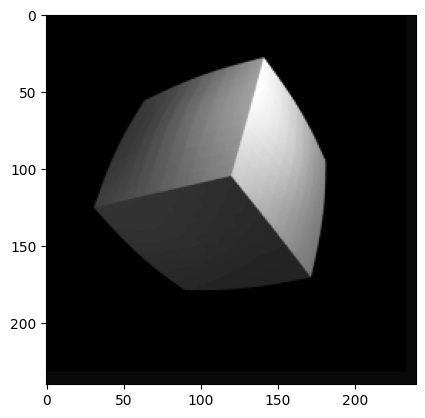

In [29]:
# example image with augmented position offset
plt.imshow(get_batch('train')[0][0].squeeze().cpu().numpy(), cmap='gray')

In [30]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 5, 1)      # (B,  1, 240, 240) -> (B,  8, 236, 236)
        self.pool1 = nn.MaxPool2d(2, 2)         # (B,  8, 236, 236) -> (B,  8, 118, 118)
        self.conv2 = nn.Conv2d(8, 16, 5, 1)     # (B,  8, 118, 118) -> (B, 16, 114, 114)
        self.pool2 = nn.MaxPool2d(2, 2)         # (B, 16, 114, 114) -> (B, 16,  57,  57)
        self.conv3 = nn.Conv2d(16, 32, 5, 1)    # (B, 16,  57,  57) -> (B, 32,  53,  53)
        self.pool3 = nn.MaxPool2d(2, 2)         # (B, 32,  53,  53) -> (B, 32,  26,  26)
        self.linear1 = nn.Linear(32 * 26**2, 128)
        self.linear2 = nn.Linear(128, 1)

    def forward(self, x: torch.tensor):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        x = x.flatten(1)
        x = F.relu(self.linear1(x))
        x = torch.squeeze(self.linear2(x))
        
        return x


100%|██████████| 2000/2000 [01:52<00:00, 17.74it/s]


Train Error	Validation Error	Baseline Error
0.05628		0.06662			0.2887


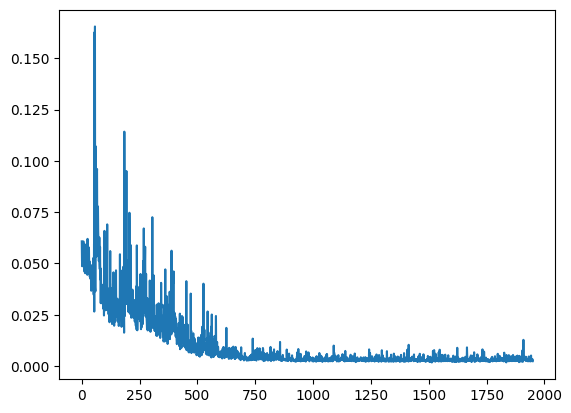

In [48]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model = Net()
model.train()
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
lr_schedule = torch.optim.lr_scheduler.LinearLR(optimizer, 1, 0.01, ITERATIONS//2)

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(EVAL_ITERATIONS)
        for k in range(EVAL_ITERATIONS):
            xb, yb = get_batch(split)
            x = model(xb)
            losses[k] = F.mse_loss(x, yb)
        out[split] = losses.mean().item()
    model.train()
    return out

loss_curve = []
for it in trange(ITERATIONS):
    xb, yb = get_batch('train')
    x = model(xb)
    loss = F.mse_loss(x, yb)
    
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    lr_schedule.step()
    loss_curve.append(loss.detach().cpu().numpy())

plt.plot(loss_curve[50:])
losses = estimate_loss()
print("Train Error\tValidation Error\tBaseline Error")
print(f"{np.sqrt(losses['train']):.4}\t\t{np.sqrt(losses['val']):.4}\t\t\t{np.sqrt(1/12):.4}")

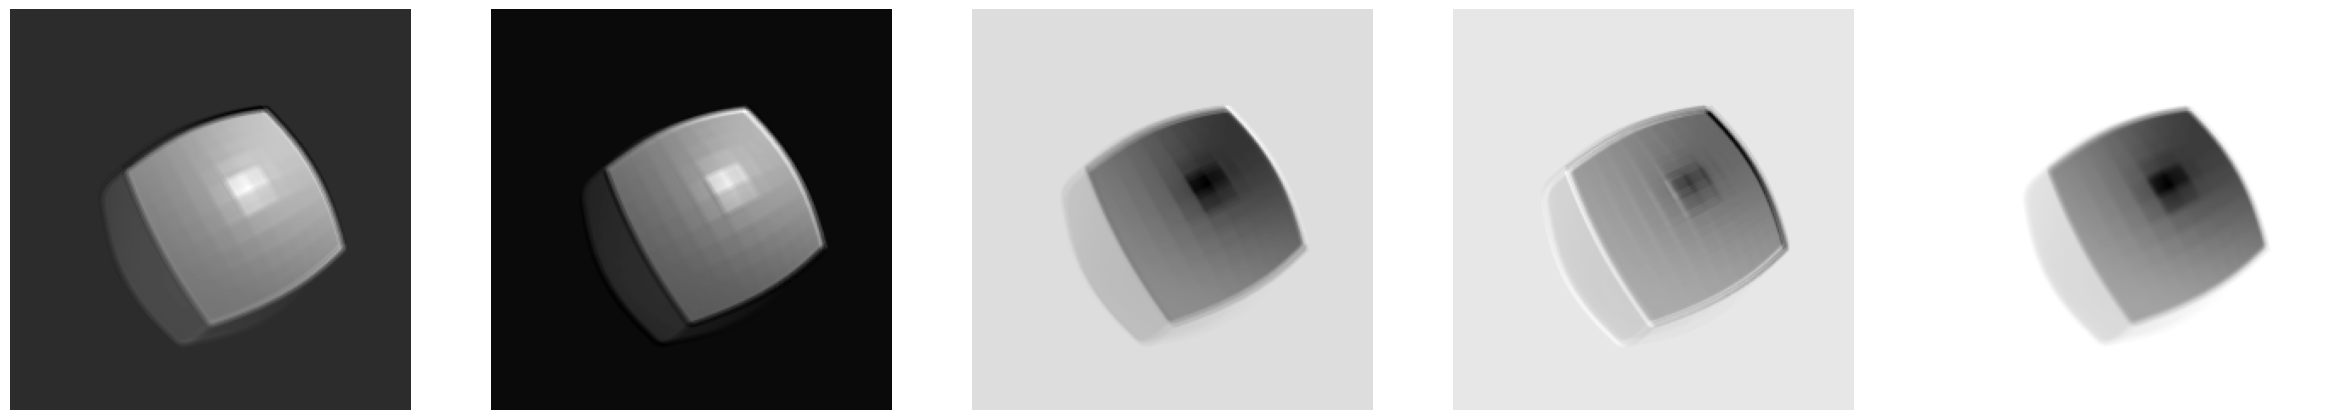

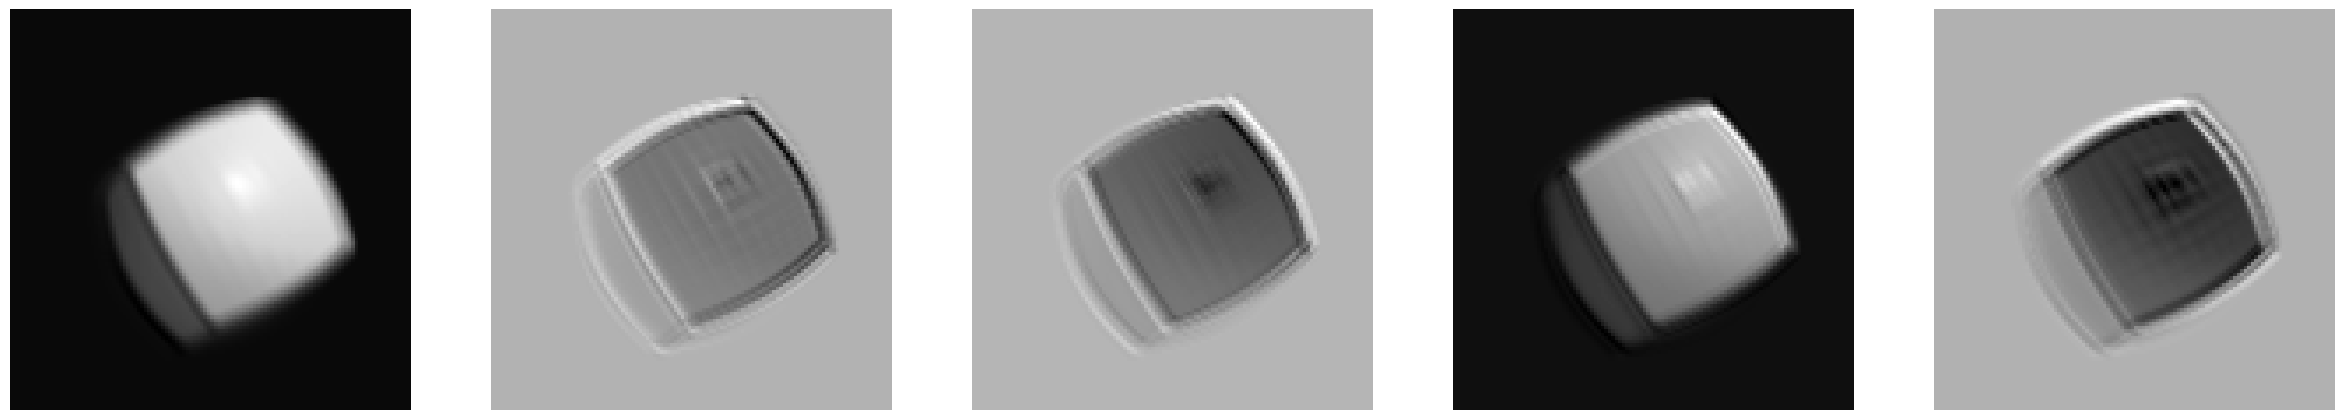

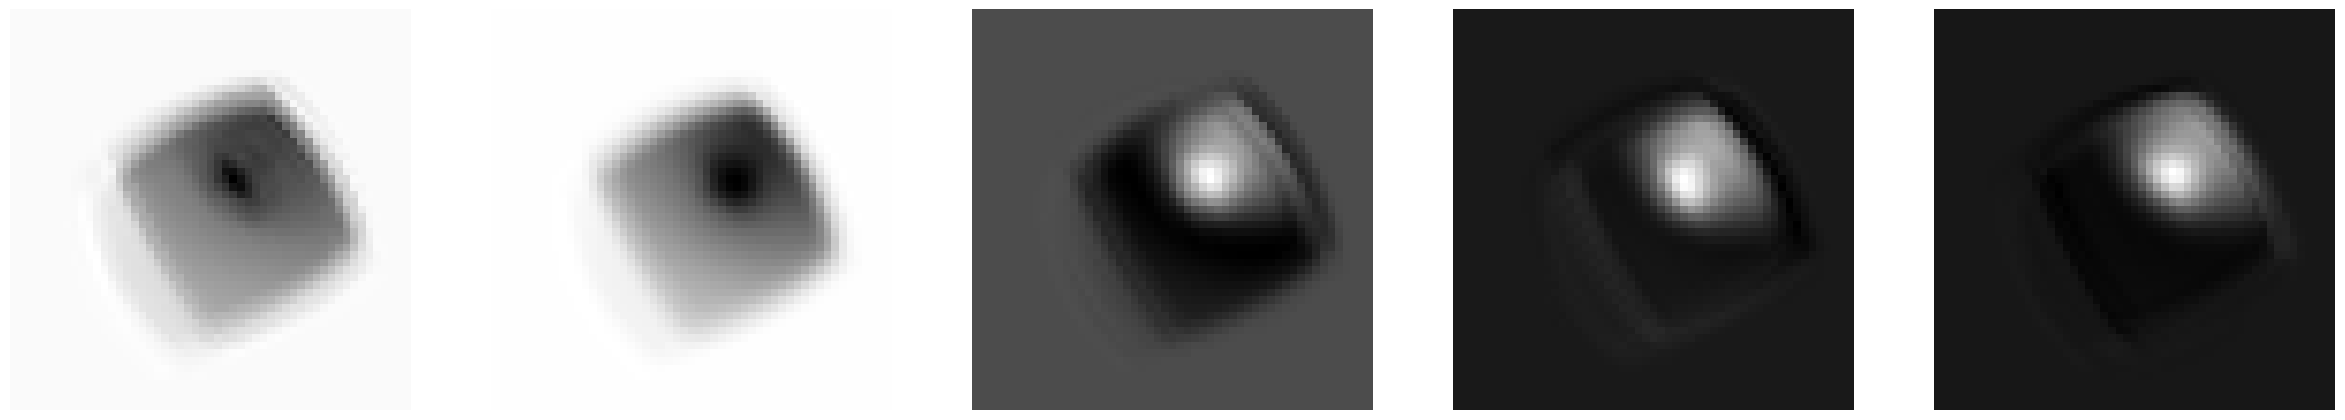

In [50]:
def plot_conv2d(conv2d: nn.Conv2d, img):

    def get_feature_maps(module, input, output):
        global feature_maps
        feature_maps = output

    hook = conv2d.register_forward_hook(get_feature_maps)

    model.eval()
    with torch.no_grad():
        _ = model(img)

    hook.remove()

    fig, axes = plt.subplots(1, 5, figsize=(30, 30))
    for i in range(5):
        axes[i].imshow(feature_maps[0, i].cpu(), cmap='gray')
        axes[i].axis('off')

    plt.show()

batch = get_batch('train')
img = batch[0][0]
batchImg = img.unsqueeze(0)

plot_conv2d(model.conv1, batchImg)
plot_conv2d(model.conv2, batchImg)
plot_conv2d(model.conv3, batchImg)

Model	| Target	| Error
0.7668	| 0.7849	| 0.018


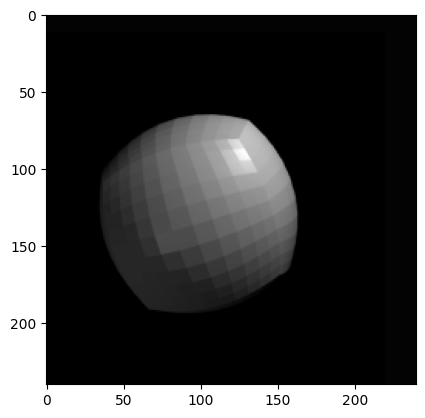

In [67]:
batch = get_batch('val')
img = batch[0][0] # img.shape is (C, W, H)
batchImg = img.unsqueeze(0) # the model expects batches, so unsqueeze to shape (B, C, W, H)

x = model(batchImg).item()
y = batch[1][0].item()
plt.imshow(img.squeeze().cpu(), cmap='gray')
print("Model\t| Target\t| Error")
print(f"{x:.4}\t| {y:.4}\t| {abs(x - y):.2}")